# Implementing the Pipeline
 - **First traffic will Find Start and End point of every Vehicle in The Given graph area**
 - **For Each Car traffic will find the shortest 3 routes according to the given traffic data**
    - In the implementation below traffic have used random function to randomly allot traffic at each road in the graph, and then show the implementation of finding the fastest 3 paths to reach destination
    - Also, traffic have currently **assumed start and end point of every vehicle to be same**, to make the problem simpler to reduce complexity.. as in case of different start and end points, the road will need to be bidirectional, increasing the number of variables in my QUBO model.
    - Another reason i assumed this unidirectional model is because traffic are solving traffic congestion during major urban events such as concerts, sports games, festivals, or political gatherings. so the people will be moving from one area (residential area) to another, **causing the traffic upstream in a single direction in such events**.
 - **Then, traffic prepared the QUBO model as proposed in my Solution PDF. Comments have been included at each step to clarify further**

In [54]:
!pip install dwave-ocean-sdk networkx dimod matplotlib

In [50]:
# Configuring DWave API Token, kindly use your own DWave API Key, 
# get one for yourself at https://cloud.dwavesys.com/leap. It have 1 min free processing time
import os
os.environ['DWAVE_API_TOKEN'] = 'YOUR_API_KEY'

### Importing Necessary Packages

In [47]:
#Packages for Quantum Computing
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
import dimod
#Packages for Classical Computing
import time
import networkx as nx # For Making Road Graphs
import matplotlib.pyplot as plt
import random
import itertools

In [48]:
class MyList(object): # Used later to find 3 shortest paths

    def __init__(self, gen):
        self.gen = iter(gen)

    def __iter__(self):
        return self.gen

    def __getitem__(self, index):
        try:
            return next(itertools.islice(self.gen, index, index+1))
        except TypeError:
            return list(itertools.islice(self.gen, index.start, index.stop, index.step))

# Some Functions which are used to create Road Graph using the NetworkX module majorly
# Well, this code was specifically designed by me to create the 3*3 graph generated below
def make_graph(row, column):
    node = row*column
    node_limit = column
    G = nx.Graph()
    H = nx.path_graph(node)
    G.add_nodes_from(H)
    counter = 0
    speed_limits = [i for i in range(40, 100, 10)]

    for i in range(node - 1):
        speed_limit = random.choice(speed_limits) # Setting Random Speed Limit on each vehicle, traffic will store this data seperately in a dataset in live model
        length = random.randint(10, 100) #Random Length initialised, will take this beforehand while setting up road graph in real world
        counter += 1
        if counter != node_limit:
            G.add_edge(i, i + 1, speed=speed_limit, length=length)
            if i + node_limit <= node - 1:
                speed_limit = random.choice(speed_limits)
                length = random.randint(10, 100)
                G.add_edge(i, i + node_limit, speed=speed_limit, length=length)
        else:
            G.add_edge(i, i + node_limit, speed=speed_limit, length=length)
            counter = 0

    return G


def add_traffic_weight(G):
    for i in G.edges:
        u, v, = i
        traffic = random.randint(1, 20) # Random Traffic in roads
        G[u][v]["traffic weight"] = traffic


def add_time_travel(G):
    for i in G.edges:
        u, v,  = i
        #metric is approximate percentage of max speed vehicle can travel on for given traffic weight, may use a formula for traffic to percentage of max speed..
        t = {1: 100, 2: 95, 3: 90, 4: 85, 5: 80, 6: 75, 7: 70, 8: 65, 9: 60, 10: 55,
             11: 50, 12: 45, 13: 40, 14: 35, 15: 30, 16: 25, 17: 20, 18: 15, 19: 10, 20: 5} 
        speed = G[u][v]["speed"]
        length = G[u][v]["length"]
        traffic = t[G[u][v]["traffic weight"]]
        G[u][v]["time travel"] = (length*60)//(traffic*speed/100)


def print_map_graph_details(G):
    for i in G.edges:
        u, v, = i
        speed = G[u][v]["speed"]
        length = G[u][v]["length"]
        traffic = G[u][v]["traffic weight"] # lower the better
        time = G[u][v]["time travel"]
        print(f"The Roadway {u, v} : permissible speed is {speed} km/h **** length is {length} km **** Traffic Weightage is {traffic} **** it takes time {time} minutes")


def find_tre_shortest_paths(G, origin_node, destination_node, overlap=None, weight=None):

    if weight == None:
        all_shortest_paths = nx.all_shortest_paths(G, source=origin_node, target=destination_node)
        path_index = MyList(all_shortest_paths)
        counter = 0

        if (len(G.nodes) <= 120) and (overlap != None):
            path_00 = [path_index[0]]
            for sh_p in all_shortest_paths:
                for p in path_00:
                    counter = 0
                    for sh in sh_p:
                        if sh in p:
                            counter += 1
                        if counter == overlap:
                            break
                    if counter == overlap:
                        break
                if counter < overlap:
                    path_00.append(sh_p)
            path = list(path_00)
            random.shuffle(path)
            path = path[0:3]
        else:
            path = [path_index[random.randint(0, len(G.nodes))] for i in range(3)]

    else:
        all_simple_paths = nx.shortest_simple_paths(G, origin_node, destination_node, weight=weight)
        path = []
        counter = 0
        for i in all_simple_paths:
            counter += 1
            path.append(i)
            if counter == 3:
                break
    return path


def paths_edges(paths: list):
    path_edges = []
    for i in paths:
        edges = [(i[j], i[j+1]) for j in range(0, len(i)-1)]
        path_edges.append(edges)
    return path_edges

In [49]:
# For my example graph
row = 3
column = 3

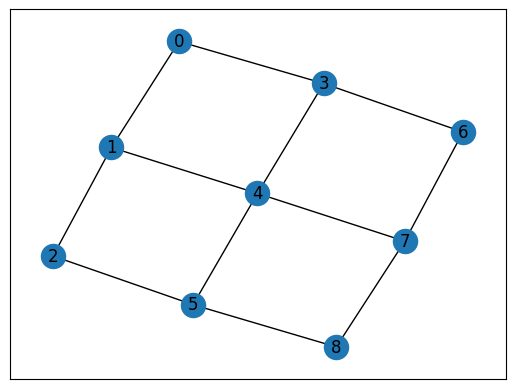

The Roadway (0, 1) : permissible speed is 60 km/h **** length is 85 km **** Traffic Weightage is 10 **** it takes time 154.0 minutes
The Roadway (0, 3) : permissible speed is 60 km/h **** length is 96 km **** Traffic Weightage is 12 **** it takes time 213.0 minutes
The Roadway (1, 2) : permissible speed is 70 km/h **** length is 37 km **** Traffic Weightage is 12 **** it takes time 70.0 minutes
The Roadway (1, 4) : permissible speed is 40 km/h **** length is 31 km **** Traffic Weightage is 9 **** it takes time 77.0 minutes
The Roadway (2, 5) : permissible speed is 70 km/h **** length is 26 km **** Traffic Weightage is 2 **** it takes time 23.0 minutes
The Roadway (3, 4) : permissible speed is 50 km/h **** length is 30 km **** Traffic Weightage is 3 **** it takes time 40.0 minutes
The Roadway (3, 6) : permissible speed is 90 km/h **** length is 38 km **** Traffic Weightage is 15 **** it takes time 84.0 minutes
The Roadway (4, 5) : permissible speed is 50 km/h **** length is 50 km **** T

In [5]:
#Generating my Graph
G = make_graph(row, column)
add_traffic_weight(G)
add_time_travel(G)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True)
plt.show()
print_map_graph_details(G)

In [6]:
origin_node = 0
destination_node = 8

The 3 shortest paths from the origin to the destination are shown below ....... 
time travel of rout [(0, 1), (1, 4), (4, 7), (7, 8)] is 5:9
time travel of rout [(0, 1), (1, 2), (2, 5), (5, 8)] is 5:10
time travel of rout [(0, 3), (3, 4), (4, 7), (7, 8)] is 5:31


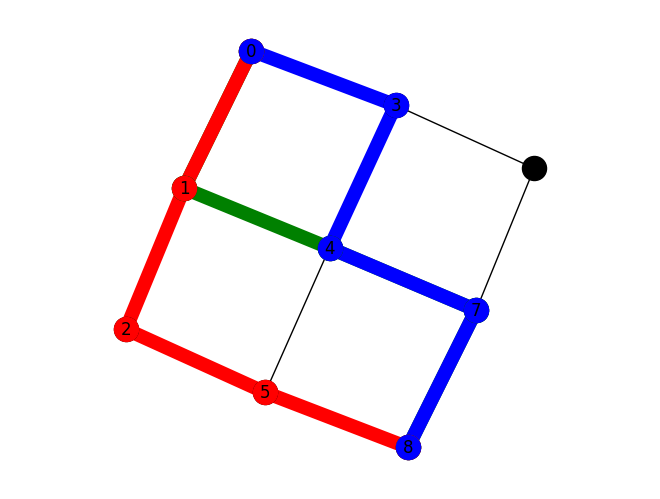

In [7]:
print("The 3 shortest paths from the origin to the destination are shown below ....... ")
paths = find_tre_shortest_paths(G, origin_node, destination_node, overlap=5, weight="time travel")
path_edges = paths_edges(paths)
for i in path_edges:
    zaman = 0
    for s in i:
        u, v = s
        zaman += G[u][v]["time travel"]
    print(f'time travel of rout {i} is {int(zaman//60)}:{int(zaman%60)}')

nx.draw(G, pos, node_color='k', with_labels=True)
nx.draw_networkx_nodes(G, pos, nodelist=paths[0], node_color='g')
nx.draw_networkx_edges(G, pos, edgelist=path_edges[0], edge_color='g', width=10)
nx.draw_networkx_nodes(G, pos, nodelist=paths[1], node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=path_edges[1], edge_color='r', width=10)
nx.draw_networkx_nodes(G, pos, nodelist=paths[2], node_color='b')
nx.draw_networkx_edges(G, pos, edgelist=path_edges[2], edge_color='b', width=10)
plt.axis('equal')
plt.show()

In [8]:
streets = G.edges()
routs_A_B = path_edges

In [39]:
num_cars=4
PENALTY=1000

In [35]:
class TrafficFlowOptimization:
    def __init__(self, number: int, routes: list, streets: list):
        self.number_of_cars = number
        self.routes = routes
        self.streets = streets

    # Create car variables based on the number of cars and routes
    def make_cars_variables(self):
        cars_variables = []
        for i in range(1, self.number_of_cars + 1):
            for j in range(1, len(self.routes) + 1):
                cars_variables.append(f'q_{i}_{j}')
        return cars_variables

    def route_for_each_cars_variables(self, cars_variables: list):
        cars_routes = dict()
        counter = 0
        for i in range(len(cars_variables)):
            cars_routes[cars_variables[i]] = self.routes[counter]
            counter += 1
            if counter == len(self.routes):
                counter = 0
        return cars_routes

    # Make a simple QUBO matrix with no initial penalties or costs
    def make_qubo(self, cars_variables: list):
        qubo = dict()
        for i in range(len(cars_variables)):
            for j in range(i, len(cars_variables)):
                qubo[(cars_variables[i], cars_variables[j])] = 0
        return qubo

    # Add cost and penalty based on the traffic conditions
    def adding_cost_and_penalty(self, qubo, routes_cars):
        print(routes_cars)
        #MAKE PENALTY TERM FOR ROUTE, CAR, STREET
        street_costs = {}
        for street in self.streets:
            u,v=street
            street_costs[(u,v)] = G[u][v]['traffic weight']
        for car_var, route in routes_cars.items():
            streets_in_route = route
            
            for street in streets_in_route:
                cost = street_costs[street] if street in street_costs else 1  # Default cost is 1 if no data
                for other_car_var, other_route in routes_cars.items():
                    # If two cars are on the same street, add a penalty
                    if car_var != other_car_var and street in other_route:
                        penalty = cost * 2  # Higher penalty for sharing congested streets
                        if( (car_var, other_car_var) in qubo.keys()):
                            qubo[(car_var, other_car_var)] += penalty
                        else:
                            qubo[(other_car_var, car_var)] += penalty
                    # Penalty for emergency vehicles (add high penalty for any delay on their route) .. 
                    # did not include in implementation yet
                    # if car is emergency:
                    #     qubo[(car_var, car_var)] += cost * 100  # Emergency vehicle prioritization
                    
                # Add a base penalty based on street conditions
                qubo[(car_var, car_var)] += cost
        for i in range(1, self.number_of_cars + 1):
            for j in range(1, len(self.routes) + 1):
                for k in range(j+1, len(self.routes) + 1):
                    qubo[(f'q_{i}_{j}',f'q_{i}_{k}')]+=2*PENALTY
                qubo[(f'q_{i}_{j}',f'q_{i}_{j}')]-=PENALTY
        return qubo

    # Solve using the D-Wave solver
    def solve_with_Dwave(self, qubo):

        bqm = dimod.BinaryQuadraticModel.from_qubo(qubo, 0)
            
        # Using D-Wave's Leap Hybrid Sampler
        # sampler = LeapHybridSampler()
        print(bqm)
        start = time.time()

        # Solve the problem using the hybrid solver
        # response = sampler.sample(bqm)

        end = time.time()
        print(f"Hybrid solver time: {end - start} seconds")

        # Print the best solution
        for datum in response.data(['sample', 'energy', 'num_occurrences']):
            counter = 0
            for i in datum.sample:
                if datum.sample[i] == 1:
                    counter += 1
                    print(i, end=" ")
            print(f"Energy: {datum.energy}, Occurrences: {datum.num_occurrences}")
            print(f"Number of variables set to 1: {counter}")
        return response
        

In [22]:
model = TrafficFlowOptimization(num_cars, routs_A_B, streets)
cars_variables = model.make_cars_variables()
routes_cars = model.route_for_each_cars_variables(cars_variables)
# print(routes_cars)
print(model.streets)
qubo = model.make_qubo(cars_variables)
model.adding_cost_and_penalty(qubo, routes_cars)
sampleset=model.solve_with_Dwave(qubo)

[(0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (3, 4), (3, 6), (4, 5), (4, 7), (5, 8), (6, 7), (7, 8)]
{'q_1_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_1_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_1_3': [(0, 3), (3, 4), (4, 7), (7, 8)], 'q_2_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_2_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_2_3': [(0, 3), (3, 4), (4, 7), (7, 8)], 'q_3_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_3_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_3_3': [(0, 3), (3, 4), (4, 7), (7, 8)], 'q_4_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_4_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_4_3': [(0, 3), (3, 4), (4, 7), (7, 8)]}
BinaryQuadraticModel({'q_1_1': -967.0, 'q_1_2': -975.0, 'q_1_3': -971.0, 'q_2_1': -967.0, 'q_2_2': -975.0, 'q_2_3': -971.0, 'q_3_1': -967.0, 'q_3_2': -975.0, 'q_3_3': -971.0, 'q_4_1': -967.0, 'q_4_2': -975.0, 'q_4_3': -971.0}, {('q_1_2', 'q_1_1'): 2040.0, ('q_1_3', 'q_1_1'): 2056.0, ('q_1_3', 'q_1_2'): 2000.0, ('q_2_1', 'q_1_1'): 132.0, ('q_2_1', 'q_1_2'): 40.0, ('q_2_1', 'q_1_3'): 5

In [27]:
# sampleset.data

In [26]:
print(routes_cars)

{'q_1_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_1_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_1_3': [(0, 3), (3, 4), (4, 7), (7, 8)], 'q_2_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_2_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_2_3': [(0, 3), (3, 4), (4, 7), (7, 8)], 'q_3_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_3_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_3_3': [(0, 3), (3, 4), (4, 7), (7, 8)], 'q_4_1': [(0, 1), (1, 4), (4, 7), (7, 8)], 'q_4_2': [(0, 1), (1, 2), (2, 5), (5, 8)], 'q_4_3': [(0, 3), (3, 4), (4, 7), (7, 8)]}


## Explaining the output:
- The Output variables set to 1 are **q_1_2, q_2_2, q_3_3, q_4_3**
- This indicates that
    - Car **labelled 1 and 2** should go through route 2 => along edges: $$[(0, 1), (1, 2), (2, 5), (5, 8)]$$
    - Car **labelled 3 and 4** should go through route 3 => along edges: $$[(0, 3), (3, 4), (4, 7), (7, 8)]$$
- Route 1 is being avoided due to more traffic on that, and hence the calculations indicated the cars to go together.

## Designing Model For Traffic Light Management
 - Implemented the Basic Traffic light control for individual intersection.
 - No additional Assumptions taken apart from what i mentioned in document.
 - Could not implement inter-related QUBO coefficients due to time constraints and lack of car route information while showing this sub-problem solution
 - If we had car route for every car, we could have implemented that too.

In [42]:
class TrafficLightOptimization:
    def __init__(self, intersections):
        self.intersections = intersections  # List of intersection names or IDs
        self.traffic_data = self.generate_random_traffic_data()  # Randomized traffic data
        self.offset=0.0
        
    # Generate random traffic data for each intersection and all 6 modes
    def generate_random_traffic_data(self):
        traffic_data = {}
        for intersection in self.intersections:
            traffic_data[intersection] = {
                'mode_1': random.randint(5, 50),  # N-S and S-N (with left turns)
                'mode_2': random.randint(5, 50),  # S-N and S-E
                'mode_3': random.randint(5, 50),  # N-S and N-W
                'mode_4': random.randint(5, 50),  # E-W and W-E (with left turns)
                'mode_5': random.randint(5, 50),  # W-E and W-S
                'mode_6': random.randint(5, 50)   # E-W and E-N
            }
        return traffic_data

    # Create traffic light variables based on the number of intersections and modes (6 states per intersection)
    def make_traffic_light_variables(self):
        traffic_light_variables = []
        for i in range(1, len(self.intersections) + 1):
            for j in range(1, 7):  # 6 modes per intersection
                traffic_light_variables.append(f'q_{i}_{j}')
        return traffic_light_variables

    # Create a QUBO matrix with penalties for conflicting lights and traffic flow
    def make_qubo(self, traffic_light_variables):
        qubo = dict()

        # # Add base QUBO penalties for conflicting lights at the same intersection
        for i in range(len(traffic_light_variables)):
            for j in range(i, len(traffic_light_variables)):
                var1, var2 = traffic_light_variables[i], traffic_light_variables[j]
                qubo[(var1, var2)] = 0
        return qubo

    # Add cost and penalty for traffic flow conditions
    def adding_cost_and_penalty(self, qubo, traffic_light_variables):
        for var in traffic_light_variables:
            intersection, mode = var.split('_')[1], var.split('_')[2]

            # Add traffic flow cost for the current mode
            traffic_flow = self.traffic_data.get(intersection, {}).get(f'mode_{mode}', 0)

            # The higher the traffic flow, the lower the penalty (maximize flow)
            qubo[(var, var)] = -traffic_flow  # Negative value to encourage high traffic flow modes
        #Penalty for Multiple modes on one intersection
        for i in self.intersections:
            for j in range(1,7): # modes
                for k in range(j+1,7): # modes
                    qubo[(f'q_{i}_{j}',f'q_{i}_{k}')]+=2*PENALTY
                qubo[(f'q_{i}_{j}',f'q_{i}_{j}')]-=PENALTY
            self.offset+=PENALTY
            
        return qubo
    # Visualize the traffic data for each mode at each intersection
    def visualize_traffic(self):
        fig, ax = plt.subplots(2, 2, figsize=(8, 8))

        # Plot traffic data at each intersection in the 2x2 grid
        for i, intersection in enumerate(self.traffic_data.keys()):
            row, col = divmod(i, 2)
            modes = self.traffic_data[intersection]
            mode_labels = ['1', '2', '3', '4', '5', '6']
            traffic_values = [modes[f'mode_{i}'] for i in range(1, 7)]
            ax[row, col].bar(mode_labels, traffic_values)
            ax[row, col].set_title(f"Intersection {intersection}")
            ax[row, col].set_ylabel("Traffic Volume")
            ax[row, col].set_xlabel("Intersection Mode")

        plt.tight_layout()
        plt.show()

    # Solve using the D-Wave solver (or simulate solving in this case)
    def solve_with_Dwave(self, qubo, method="hybrid"):
        if method == "hybrid":
            bqm = dimod.BinaryQuadraticModel.from_qubo(qubo, self.offset)
            print(bqm)            
            # Simulate solving for now (D-Wave solving can be added later)
            print("Solving the problem using a simulated D-Wave solver")
            start = time.time()

            # QUBO solving using LeapHybridSampler
            sampler=LeapHybridSampler()
            response = sampler.sample(bqm)

            end = time.time()
            print(f"Hybrid solver time: {end - start} seconds")

        # Print the best solution
        for datum in response.data(['sample', 'energy', 'num_occurrences']):
            counter = 0
            for i in datum.sample:
                if datum.sample[i] == 1:
                    counter += 1
                    print(i, end=" ")
            print(f"Energy: {datum.energy}, Occurrences: {datum.num_occurrences}")
            print(f"Number of variables set to 1: {counter}")


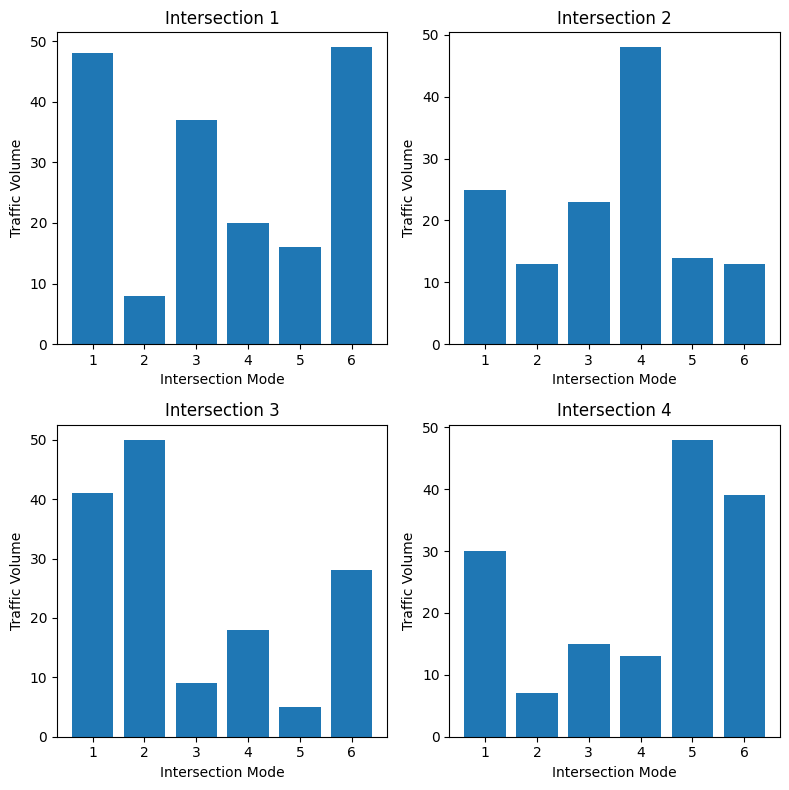

BinaryQuadraticModel({'q_1_1': -1048.0, 'q_1_2': -1008.0, 'q_1_3': -1037.0, 'q_1_4': -1020.0, 'q_1_5': -1016.0, 'q_1_6': -1049.0, 'q_2_1': -1025.0, 'q_2_2': -1013.0, 'q_2_3': -1023.0, 'q_2_4': -1048.0, 'q_2_5': -1014.0, 'q_2_6': -1013.0, 'q_3_1': -1041.0, 'q_3_2': -1050.0, 'q_3_3': -1009.0, 'q_3_4': -1018.0, 'q_3_5': -1005.0, 'q_3_6': -1028.0, 'q_4_1': -1030.0, 'q_4_2': -1007.0, 'q_4_3': -1015.0, 'q_4_4': -1013.0, 'q_4_5': -1048.0, 'q_4_6': -1039.0}, {('q_1_2', 'q_1_1'): 2000.0, ('q_1_3', 'q_1_1'): 2000.0, ('q_1_3', 'q_1_2'): 2000.0, ('q_1_4', 'q_1_1'): 2000.0, ('q_1_4', 'q_1_2'): 2000.0, ('q_1_4', 'q_1_3'): 2000.0, ('q_1_5', 'q_1_1'): 2000.0, ('q_1_5', 'q_1_2'): 2000.0, ('q_1_5', 'q_1_3'): 2000.0, ('q_1_5', 'q_1_4'): 2000.0, ('q_1_6', 'q_1_1'): 2000.0, ('q_1_6', 'q_1_2'): 2000.0, ('q_1_6', 'q_1_3'): 2000.0, ('q_1_6', 'q_1_4'): 2000.0, ('q_1_6', 'q_1_5'): 2000.0, ('q_2_1', 'q_1_1'): 0.0, ('q_2_1', 'q_1_2'): 0.0, ('q_2_1', 'q_1_3'): 0.0, ('q_2_1', 'q_1_4'): 0.0, ('q_2_1', 'q_1_5'): 0.0,

In [45]:
intersections = ['1', '2', '3', '4']  # Define 4 intersections
optimizer = TrafficLightOptimization(intersections)

# Visualize random traffic at each intersection
optimizer.visualize_traffic()

# Make traffic light variables
traffic_light_variables = optimizer.make_traffic_light_variables()

# Create the QUBO model
qubo = optimizer.make_qubo(traffic_light_variables)

# Add traffic flow costs and penalties
optimizer.adding_cost_and_penalty(qubo, traffic_light_variables)

# Solve the problem (this part is a placeholder for actual D-Wave solving)
optimizer.solve_with_Dwave(qubo)

## Interpreting the results
 - q_i_j=1 indicate that ith intersection needs to be in mode j.
 - Active Variables(having value=1) are: $$\left( q_{1,6}, q_{2,4}, q_{3,2}, q_{4,5} \right)$$
 - intersection 1 is in mode 6
 - intersection 2 is in mode 4
 - intersection 3 is in mode 2
 - intersection 4 is in mode 5

for the above results

# Setting the above Solutions in My Pipeline
1. We will retrieve all the position data of each car and traffic rating of each road using GPS(Input)
2. Then We Frame The Graph in Each Case(Traffic Lights and Navigation Code Solution shown seperately above)
3. then we formulate QUBO coefficients for each case using adding_cost_and_penalty() function in each case , and pass it onto BQM(Binary Quadratic Models).
4. Pass it onto DWave hybrid solve to give the optimized solution(**QUANTUM PART**)
5. Uderstanding and parsing output(Shown and explained output in markdown cell in each case above)
6. Then passing on the optimized output to the respective devices(Car for navigation, traffic lights for signal,etc)
7. **NOTE: In Case of Emergency Vehicles, we can assume it to be a large number(lets say 100, this number depends on urgency of the vehicle) of vehicles moving together.. which will make the model assume that it needs very light traffic(faster navigtion route) and needs to be cleared out of traffic light faster than others.**